<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/ArBert_AuSTR_classweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/

In [2]:
#importing packages
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [3]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
checkpoint_directory = "ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Dataset specification (ans-stance)
raw_datasets = load_dataset("bigIR/AuSTR")
dataset_directory = "AuSTR"
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

AuSTR_train.tsv:   0%|          | 0.00/321k [00:00<?, ?B/s]

AuSTR_dev.tsv:   0%|          | 0.00/112k [00:00<?, ?B/s]

AuSTR_test.tsv:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 488
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

In [31]:
from datasets import concatenate_datasets

# Merge the two datasets
merged_dataset = concatenate_datasets([tokenized_datasets['train'], tokenized_datasets['validation']])

# Shuffle the merged dataset
shuffled_dataset = merged_dataset.shuffle(seed=42)

# Check the result
print(merged_dataset)

tensor([0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
        0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0,
        0, 2, 2, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0,
        2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [5]:
#Evaluation Metrics
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")


In [6]:
import os
from datetime import datetime

# Get the current date and time in the desired format
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the folder name by combining the date, time, and custom string
experiment_name = f"{checkpoint_directory}_{dataset_directory}_{current_time}"

# Create the folder
os.makedirs(experiment_name)


# Define the name of the subdirectory inside the main folder
results_directory = "results"
logs_directory = "logs"

# Create the subdirectory inside the main folder
results_path = os.path.join(experiment_name, results_directory)
os.makedirs(results_path)

logs_path = os.path.join(experiment_name, logs_directory)
os.makedirs(logs_path)


# Get the full path (access link) to the subdirectory
experiment_full_path  = os.path.abspath(experiment_name)
results_full_path = os.path.abspath(results_path)
logs_full_path = os.path.abspath(logs_path)

print(f"Results directory: {results_full_path}")
print(f"Logs directory: {logs_full_path}")
print(f"experiment directory: {experiment_full_path}")

Results directory: /content/ARBERT_AuSTR_2024-09-12_09-38-15/results
Logs directory: /content/ARBERT_AuSTR_2024-09-12_09-38-15/logs
experiment directory: /content/ARBERT_AuSTR_2024-09-12_09-38-15


In [32]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have your labels as a NumPy array or list
labels = np.array(merged_dataset['labels'])  # Example label array

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

{0: 1.379746835443038, 1: 1.8319327731092436, 2: 0.5782493368700266}


In [26]:
from torch import nn
# Define the weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device)) # Move class_weights_tensor to the same device as the model

# Define a custom compute_loss function
def compute_weighted_loss(model, inputs):
    labels = inputs.get("labels")
    # Forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # Compute the loss using class weights
    loss = loss_fn(logits, labels)
    return loss

In [24]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(model.device) # Ensure labels are on the same device as the model
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute the loss using class weights
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

In [14]:
# trainning hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                   # Fewer epochs to avoid overfitting
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",           # Regular evaluation
    eval_steps=25,                         # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,           # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-5,                    # Lower learning rate
    weight_decay=0.01,                     # Apply weight decay
    max_grad_norm=1.0,                     # Gradient clipping
    logging_dir="./logs",
    logging_steps=100,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2024)  # You can use any fixed seed value

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

In [23]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()


In [33]:
initial_model_state = model.state_dict()  # Save initial weights

for epochs in [5]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()
    #trainer.save_model(f"{experiment_full_path}/epoch_{epochs}")
    #if epochs == 3 : trainer_1 = trainer.train()
    #elif epochs == 5 : trainer_2 = trainer.train()
    #elif epochs == 10 : trainer_3 = trainer.train()

Step,Training Loss,Validation Loss,F1
25,No log,0.438136,0.839653
50,No log,0.376098,0.887439
75,No log,0.405388,0.889891
100,0.044500,0.429080,0.889891
125,0.044500,0.458234,0.871966
150,0.044500,0.506111,0.859827
175,0.044500,0.535101,0.864681
200,0.037800,0.491151,0.873824
225,0.037800,0.514086,0.869467
250,0.037800,0.540957,0.871661


In [43]:
trainer.train()

Step,Training Loss,Validation Loss,F1
25,No log,1.169388,0.845183
50,No log,1.077922,0.858822
75,No log,1.242916,0.832331
100,0.010500,1.302568,0.836343
125,0.010500,1.137972,0.850590
150,0.010500,1.106398,0.828838
175,0.010500,0.959132,0.859383
200,0.047100,1.048484,0.844170
225,0.047100,1.089494,0.828012
250,0.047100,1.126666,0.824083


TrainOutput(global_step=305, training_loss=0.02108301004360537, metrics={'train_runtime': 322.2231, 'train_samples_per_second': 7.572, 'train_steps_per_second': 0.947, 'total_flos': 641996739256320.0, 'train_loss': 0.02108301004360537, 'epoch': 5.0})

In [45]:
model.load_state_dict(initial_model_state)  # Reset model weights
trainer.train()

Step,Training Loss,Validation Loss,F1
25,No log,1.091289,0.845470
50,No log,1.152011,0.833679
75,No log,1.038858,0.859622
100,0.010300,1.085750,0.859383
125,0.010300,1.102412,0.854192
150,0.010300,1.111891,0.855690
175,0.010300,1.117896,0.850471
200,0.002500,1.119998,0.841570
225,0.002500,1.105718,0.840243
250,0.002500,1.115782,0.846770


Step,Training Loss,Validation Loss,F1
25,No log,1.149313,0.829285


TrainOutput(global_step=305, training_loss=0.005684900898906235, metrics={'train_runtime': 321.6054, 'train_samples_per_second': 7.587, 'train_steps_per_second': 0.948, 'total_flos': 747242106347520.0, 'train_loss': 0.005684900898906235, 'epoch': 5.0})

In [ ]:
model.load_state_dict(initial_model_state)  # Reset model weights
CustomTrainer.train()

Step,Training Loss,Validation Loss,F1
25,No log,1.116571,0.846770
50,No log,1.110593,0.850751
75,No log,1.098395,0.850751
100,0.006500,1.132251,0.845470
125,0.006500,1.155419,0.840243
150,0.006500,1.161502,0.840243
175,0.006500,1.170297,0.840243
200,0.002300,1.166788,0.840243
225,0.002300,1.143960,0.845470
250,0.002300,1.152105,0.840243


In [41]:
initial_model_state = model.state_dict()  # Save initial weights

for epochs in [5]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()

Step,Training Loss,Validation Loss,F1
25,No log,1.223003,0.836343
50,No log,1.138130,0.847011
75,No log,1.144041,0.847011
100,0.004400,1.153299,0.855712
125,0.004400,1.152087,0.840308
150,0.004400,1.162079,0.827408
175,0.004400,1.026469,0.835688
200,0.015900,1.045465,0.862037
225,0.015900,1.088141,0.856057
250,0.015900,1.122578,0.850590


In [34]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r {experiment_full_path} /content/drive/MyDrive

Mounted at /content/drive


In [39]:
def calculate_ece(y_true, y_prob, num_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

def plot_reliability_diagram_with_bars(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram with bars for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins)

    # Ensure the lengths of prob_true and prob_pred match
    if len(prob_true) != len(prob_pred):
        min_len = min(len(prob_true), len(prob_pred))
        prob_true = prob_true[:min_len]
        prob_pred = prob_pred[:min_len]

    # Plot the reliability diagram with bars
    plt.figure(figsize=(8, 6))
    plt.bar(prob_pred, prob_true, width=0.1, edgecolor='k', alpha=0.7, label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram with Bars for Class {class_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

For a three-label classification problem, you can calculate the reliability diagram and Expected Calibration Error (ECE) for each class by treating the problem as multiple binary classification tasks (one-vs-rest for each class). This is typically done by transforming the problem into three binary sub-problems, one for each class.



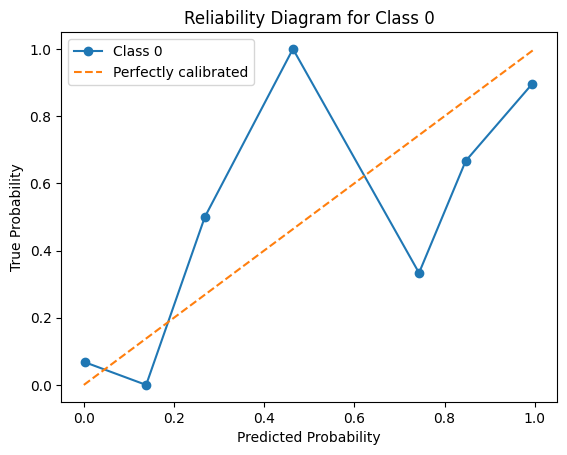

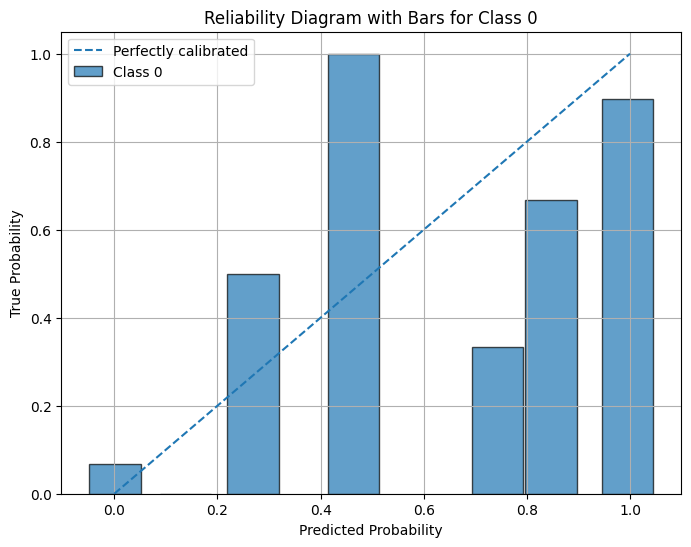

Expected Calibration Error (ECE) for Class 0: 26.07196518317829


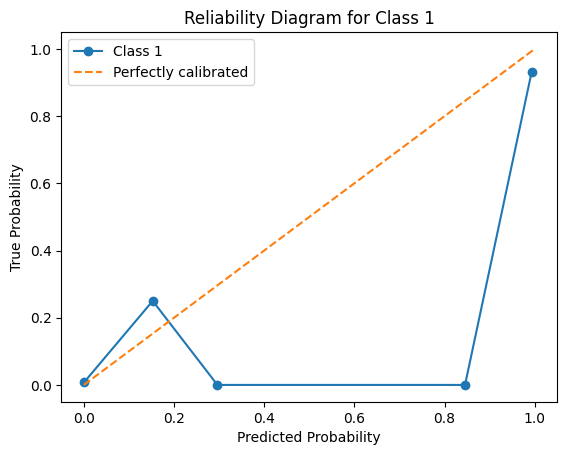

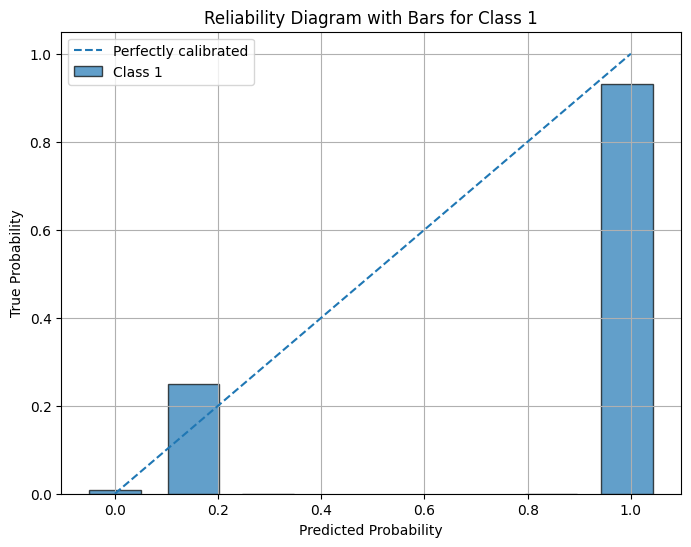

Expected Calibration Error (ECE) for Class 1: 20.541638766649296


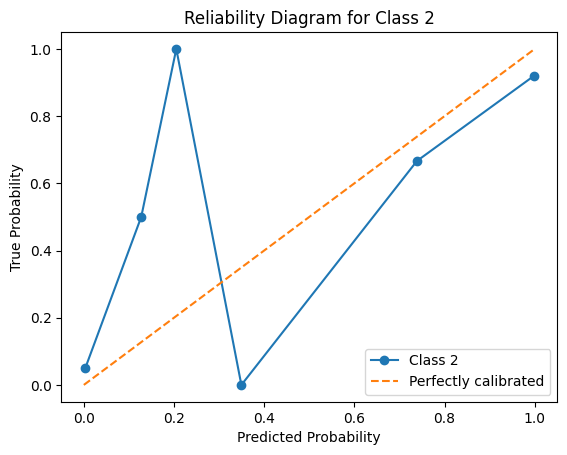

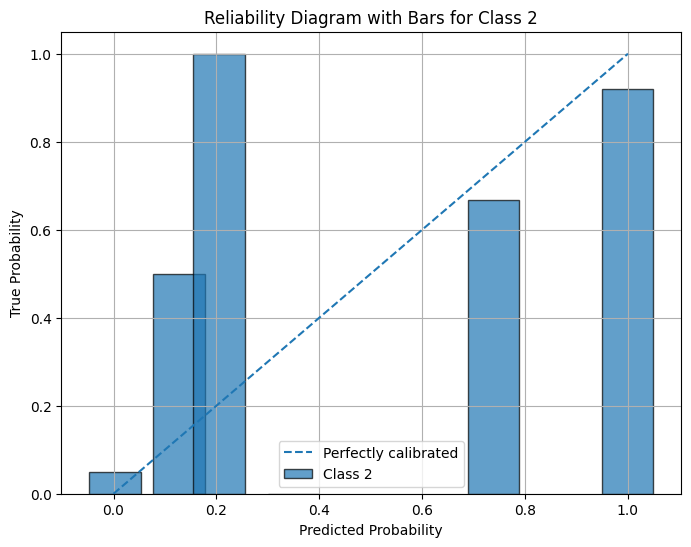

Expected Calibration Error (ECE) for Class 2: 26.916863760814035


In [36]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])

probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

bins=10

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")



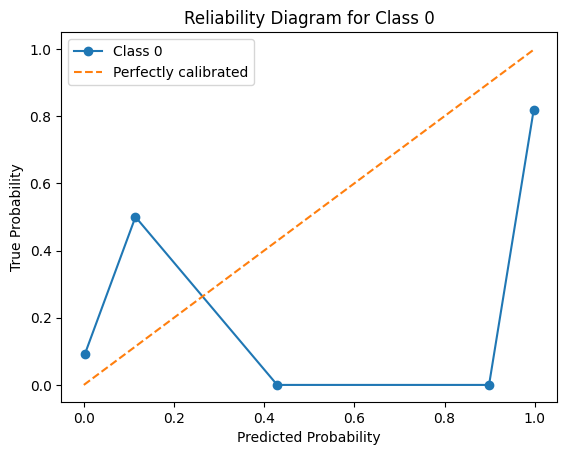

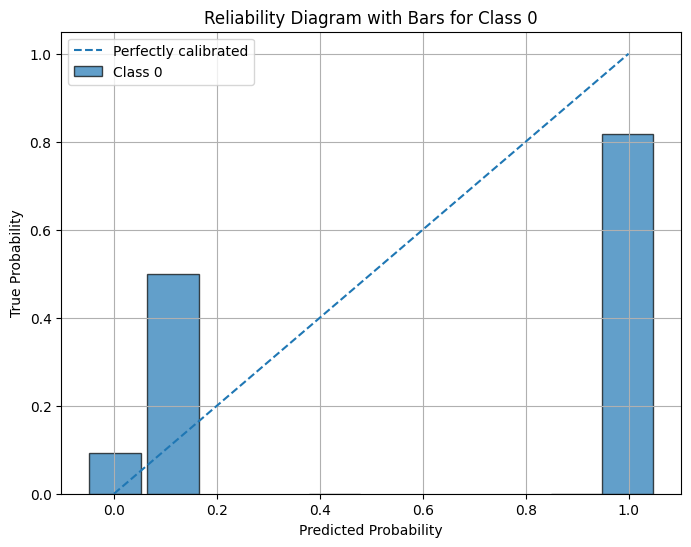

Expected Calibration Error (ECE) for Class 0: 31.114588785976167


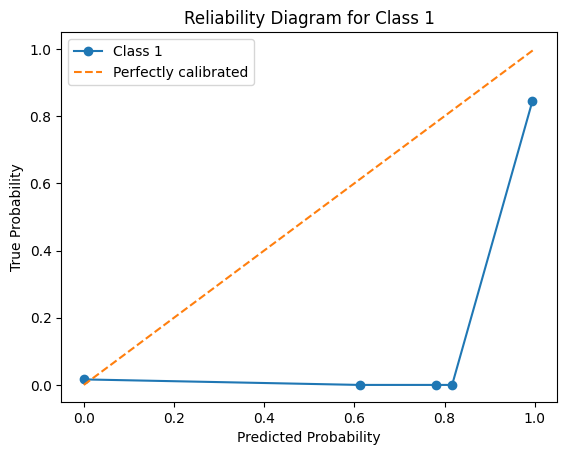

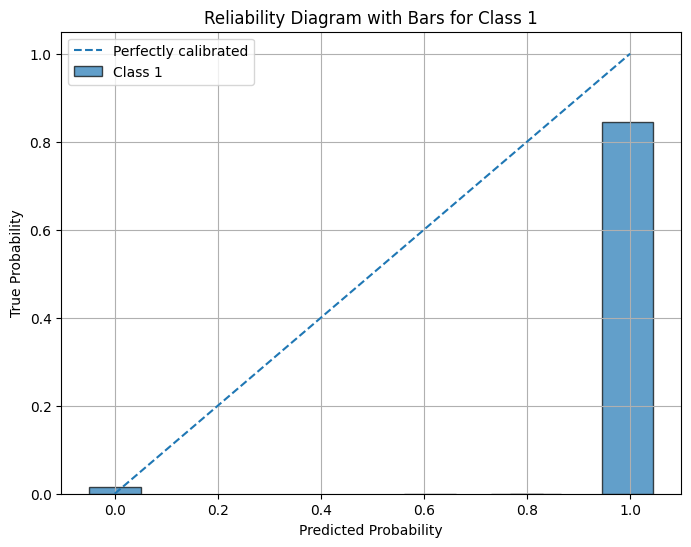

Expected Calibration Error (ECE) for Class 1: 37.29245578646072


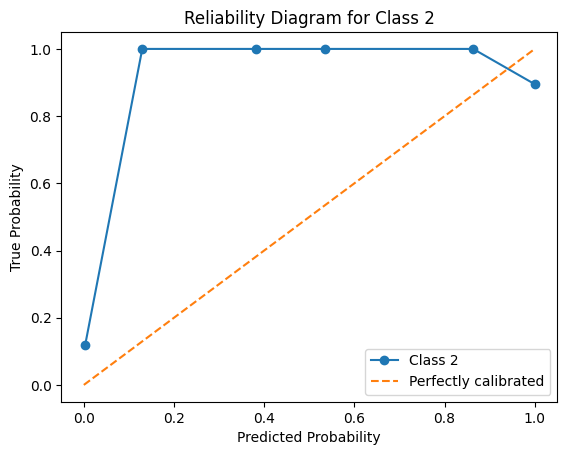

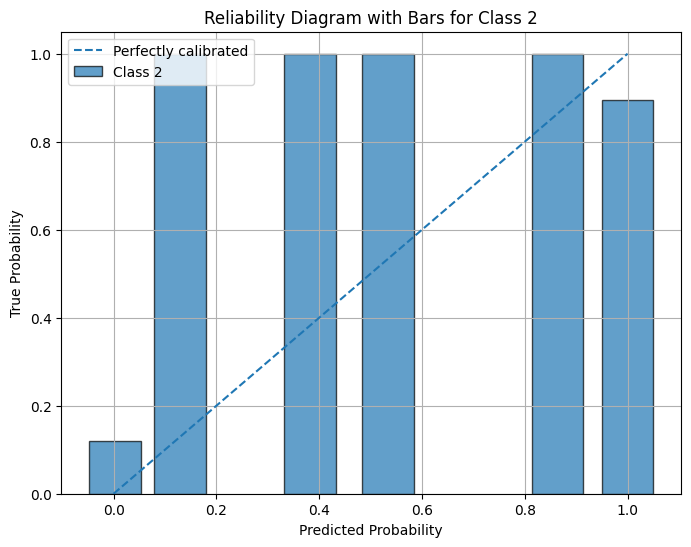

Expected Calibration Error (ECE) for Class 2: 36.28806609194805


In [40]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])

probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

bins=10

# Loop over each class (0, 1, 2) and calculate reliability diagram and ECE
for class_idx in range(n_classes):
    # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
    y_true_binary = (true_labels == class_idx).astype(int)

    # Extract probabilities for the current class
    y_prob = probabilities[:, class_idx]

    # Plot reliability diagram for the current class
    plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)
    plot_reliability_diagram_with_bars(y_true_binary, y_prob, class_idx, num_bins=bins)

    # Calculate and print ECE for the current class
    ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
    print(f"Expected Calibration Error (ECE) for Class {class_idx}: {ece}")

